### [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [187]:
import math, random, torch
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline

In [188]:
# verbose = True   # print calculation output and weights and bias matrices 
verbose = False  # print calculation output only

In [189]:
def plot_losses(losses):
  # import matplotlib.pyplot as plt
  
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

In [190]:
def print_parameters(parameters):
  # number of parameters (e.g sum (weights + bias to each neuron and output))
  # MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
  # print(f'Number of parameters in MLP(2, [3, 3, 1]): {len(parameters())}\n')
  print(f'Total parameters: {len(parameters())}\n')  

  # print first 5 parameters
  for i, v in enumerate(parameters()):
    if i < 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')
  
  print('---')

  # print last 5 parameters   
  for i, v in enumerate(parameters()):
    if i >= len(parameters()) - 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')

In [191]:
def get_wt_n_b_mats(layers, verbose=False):
  ''' Get neuron's weights and bias for each layer.
  Inputs: If n = MLP(2, [3, 3, 1]), input is n.layers.

  return: two lists of np.arrays. The first list is weight matrix for each layer
          The second list is the bias matrix for each layer 
  '''
  layer_cnt = len(layers)  # number of layers
  w_mats = []  # list of weights matrix for each layer 
  b_mats = []  # list of bias matrix for each layer
  if verbose:
    print(f'layer_cnt: {layer_cnt}\n')
  for i, layer in enumerate(layers):
      neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer
      if verbose: 
        print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

        print('----')
      b_mat = []  # accumulate neuon's bias for each row     
      for j, neuron in enumerate(layer.neurons):
          if verbose:
            print(f'layer: {i}, neuron {j}')
          b = neuron.b.data  # bias of neuron 
          w_row = []  # accumulate neuon's weights for each row
          b_row = []  # accumulate neuon's bias for each row
          for k, w in enumerate(neuron.w):
              w_row.append(w.data)
              if verbose:
                print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
          if j == 0:            
              w_mat = np.array([w_row])
          else:
              w_mat = np.vstack((w_mat, w_row))
          
          b_mat.append(b)
          if verbose:
            print(f'b:  {b:10.7f}\n')
            print(f'b:  {b:10.7f}')        
            print(f'b_mat:  {b_mat}\n')
      w_mats.append(w_mat)  
      b_mats.append(np.array([b_mat]))        
      if verbose:
          print('------')

  zipped_w_n_b = zip(w_mats, b_mats)
  if verbose:
    for i, w_n_b in enumerate(zipped_w_n_b):
      print(f'layer: {i}')  # 1st layer is 0    
      print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
      print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  

  return w_mats, b_mats

In [192]:
def forward_pass(layers, verbose=verbose):
  # Get Neural Network's Weights and Biases Matrices
  # w_mats, b_mats = get_wt_n_b_mats(n.layers, verbose=verbose)
  w_mats, b_mats = get_wt_n_b_mats(layers, verbose=verbose)

  # Calculate Neural Network Output and Loss with Matrix Multiplication
  for layer in range(len(layers)):
    if layer == 0:  # first layer, use given inputs xs as inputs
      input = xs_mats_T[layer]
    else:  # after first layer, use outputs from preceding layers as inputs
      input = output

    weights = w_mats[layer]
    bias = np.transpose(b_mats[layer])

    weights_x_input = np.matmul(weights, input)
    weights_x_input_plus_bias = weights_x_input + bias

    # output = np.tanh(np.matmul(weights, input) + bias)
    output = np.tanh(weights_x_input_plus_bias)

    print(f'{"-"*50}')
    print(f'Calculate Output of Layer: {layer}')    
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_+_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')    

    # print(f'output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    
    print(f'Layer {layer} Output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    

  yout = output[0]
  err = (yout - ys)
  err_sq = (err**2)
  loss_sum = err_sq.sum()
  loss_mean = err_sq.mean()

  # print(f'-- Manual calculation results of neural network output and prediction error --')
  print(f'-- Results of neural network outputs and Loss --')  
  print(f'yout:           {yout}')   
  print(f'desired output: {ys}')   
  print(f'err:            {err}')
  print(f'err_sq:         {err_sq}')
  print(f'loss_mean:      {loss_mean}')
  print(f'loss_sum:       {loss_sum}')

  return yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats


### Micrograd Classes and Functions<br>* limited to neural network with one output, e.g. MLP(2, [3, 1])<br>* neural network with multiple outputs, e.g.  MLP(2, [3, 3]), will produce errors in backward pass 

In [193]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [194]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [195]:
class Neuron:
    
    def __init__(self, nin):
        # random numbers evenly distributed between -1 and 1    
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

#   &nbsp;
# - Human Brain and Artificial Neural Network - 

### Neurons in Human Brain
![](..\karpathy\img\neuron_of_human_brain.png)

### Simple Artificial Neural Network<br>* input layer: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2 nodes<br>* hidden layer 1: &nbsp;3 nodes<br>* hidden layer 2:&nbsp;&nbsp;3 nodes<br>*  output layer: &nbsp;&nbsp;&nbsp; 1 node<br>* node's bias and activation function are not shown

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\MLP (2, [3, 3, 1]).png">

### Artificial Neuron Function

<img src="..\karpathy\img\Artificial Neuron Function.png">

#   &nbsp;
# - Visualize Math Operations in a Hidden Layer -

### * Assume hidden layer with two inputs (X0, X1), and three neurons (b0, b1, b2)<br>* Two sets of inputs (X0, X1) are shown in different shades of gray<br>* Two sets of outputs (Y0, Y1, Y2) are shown in corresponding shades of gray<br>* Multiple sets of inputs are processed in one matrix operation 

<img src="..\karpathy\img\Hidden Layer Matrix Operations.png">

# &nbsp;
# - Create Simple Neural Network -
##### MLP(2, [3, 3, 1])<br>* 2 input nodes<br>* 3 neurons in hidden layer 1<br>* 3 neurons in hidden layer 2<br>* 1 output node
##### Initialize Neurons Parameters <br>* parameters in layer 1: 3 neurons * (2 inputs + 1 bias) = &nbsp;&nbsp;&nbsp;&nbsp;  9<br>* parameters in layer 2: 3 neurons * (3 neurons + 1 bias) = 12<br>* parameters in layer 3: 1 output * (3 neurons + 1 bias) = &nbsp;&nbsp;&nbsp; 4<br>*  total parameters: 25

In [196]:
# create neural network and initialize weights and biases
n = MLP(2, [3, 3, 1])

# if verbose:
if True:
  print("Neuron parameters, initialized with random numbers")
  print_parameters(n.parameters)

Neuron parameters, initialized with random numbers
Total parameters: 25

i:  0,  -0.0173241433
i:  1,   0.3754123341
i:  2,  -0.2444192365
i:  3,  -0.7889267695
i:  4,   0.3390346687
---
i: 20,   0.7612217984
i: 21,  -0.9127273314
i: 22,   0.1204487103
i: 23,  -0.8494186046
i: 24,   0.1261219525


# &nbsp;
# - Set Inputs, Desired Outputs, Learning Rate -
##### Inputs<br>* 1st set: [2.0, 3.0]<br>* 2nd set: [3.0, -1.0]
##### Desired Outputs<br>* [1.0, -1.0] for all input sets
##### Learning Rate<br>* 0.05

In [197]:
# inputs
xs = [
  [2.0, 3.0],
  [3.0, -1.0]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [198]:
# if True:
if verbose:
	# print weights and bias of each layer
	for i, layer in enumerate(n.layers):
		neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer 
		print(f'layer: {i}, neuron_cnt: {neuron_cnt}, layer: {layer}')

# &nbsp;
# - Calculate Neural Network Outputs and Loss (i.e. Prediction Errors) -
##### * transpose inputs<br>* select activation function<br>* calculate output, (a.k.a) Forward Pass<br>* calculate Loss

##### Transpose Inputs

In [199]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 2)
xs_mats:
[array([[ 2.,  3.],
       [ 3., -1.]])]

xs_mats_T[0].shape: (2, 2)
xs_mats_T:
[array([[ 2.,  3.],
       [ 3., -1.]])]


##### Common Activation Functions

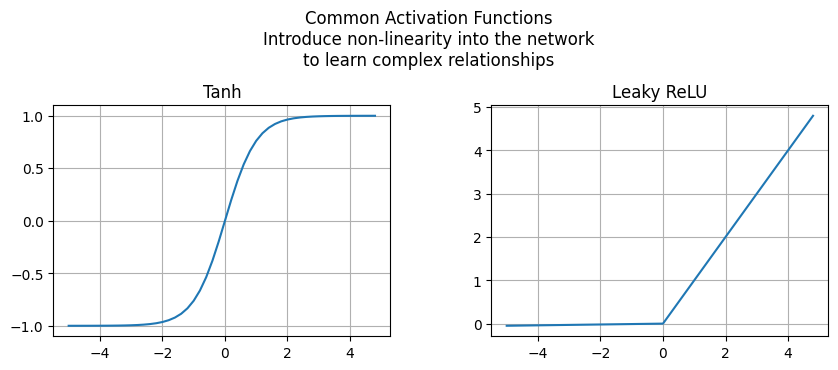

In [200]:
# Common Activation Functions
x = np.arange(-5, 5, 0.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(x, np.tanh(x))
ax1.set_title("Tanh")
ax1.grid()

a = x[x < 0]*0.01
b = x[x >= 0]
y = np.concatenate((a, b))
ax2.grid()
ax2.plot(x, y)
ax2.set_title("Leaky ReLU")

plt_title = "Common Activation Functions\nIntroduce non-linearity into the network\nto learn complex relationships"
plt.suptitle(plt_title , fontsize=12, y=1.2)
plt.subplots_adjust(wspace=0.3)
plt.show()

##### Calculate Outputs and Loss Using Tanh Activation

In [201]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[-0.01732414  0.37541233]
 [-0.78892677  0.33903467]
 [ 0.95581851  0.14310918]]

input (2, 2):
[[ 2.  3.]
 [ 3. -1.]]

weights_x_inputs (3, 2):
[[ 1.09158872 -0.42738476]
 [-0.56074953 -2.70581498]
 [ 2.34096456  2.72434635]]

bias (3, 1):
[[-0.24441924]
 [ 0.15124286]
 [-0.77232786]]

weights_x_inputs_+_bias (3, 2):
[[ 0.84716948 -0.671804  ]
 [-0.40950668 -2.55457212]
 [ 1.5686367   1.9520185 ]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.68958785 -0.5861653 ]
 [-0.38805372 -0.98799005]
 [ 0.91680864  0.9604761 ]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[ 0.97126236  0.52670277  0.14074247]
 [-0.19165559 -0.73045225 -0.08136838]
 [-0.49960006  0.25139302 -0.77003921]]

input (3, 2):
[[ 0.68958785 -0.5861653 ]
 [-0.38805372 -0.98799005]
 [ 0.91680864  0.9604761 ]]

weights_x_inputs (3, 2):
[[ 0.59441566 -0.95451761

In [202]:
print(f'-- Neural network outputs and Loss --')
print(f'yout:           {yout} <-- neural network output')   
print(f'desired output: {ys}')   
print(f'err:            {err}')
print(f'err_sq:         {err_sq}')
print(f'loss_mean:      {loss_mean}')
print(f'loss_sum:       {loss_sum} <-- sum(prediction_error)^2')


-- Neural network outputs and Loss --
yout:           [-0.22477133  0.57972836] <-- neural network output
desired output: [1.0, -1.0]
err:            [-1.22477133  1.57972836]
err_sq:         [1.5000648  2.49554168]
loss_mean:      1.9978032399830394
loss_sum:       3.995606479966079 <-- sum(prediction_error)^2


In [203]:
# save original parameters
param_org = [p.data for p in n.parameters()]

#   &nbsp;
# - How Artificial Neural Network Learns -

##### * calculate gradients (i.e. changes in Loss w.r.t. changes in each parameter)<br>* use gradients to adjust parameters in direction of less Loss<br>* repeat the steps

##### Example of calculating gradient for parameter W0<br>* calculate outputs and Loss<br>* increase W0 by small amount, e.g. 0.00001<br>* recalculate outputs and Loss<br>* calculate gradient (W0_grad = changes_in_Loss / changes_in_W0)
##### Increase W0 by small amount

In [204]:
# Increase W1 by h
h = .00001
loss_sum_before = loss_sum
print(f'loss_sum before increase Wo:  {loss_sum_before:10.7f}')
W0_before = n.parameters()[0].data  # W1
print(f'W0_before:                    {W0_before:10.7f}')
n.parameters()[0].data += h
W0_after = n.parameters()[0].data
print(f'W0_after:                     {W0_after:10.7f}') 
W0_dif = W0_after - W0_before
print(f'W0_dif:                       {W0_dif:10.7f} <-- increased W0 by a small amount') 

loss_sum before increase Wo:   3.9956065
W0_before:                    -0.0173241
W0_after:                     -0.0173141
W0_dif:                        0.0000100 <-- increased W0 by a small amount


##### Recalculate output and Loss with small changes in W0

In [205]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[-0.01731414  0.37541233]
 [-0.78892677  0.33903467]
 [ 0.95581851  0.14310918]]

input (2, 2):
[[ 2.  3.]
 [ 3. -1.]]

weights_x_inputs (3, 2):
[[ 1.09160872 -0.42735476]
 [-0.56074953 -2.70581498]
 [ 2.34096456  2.72434635]]

bias (3, 1):
[[-0.24441924]
 [ 0.15124286]
 [-0.77232786]]

weights_x_inputs_+_bias (3, 2):
[[ 0.84718948 -0.671774  ]
 [-0.40950668 -2.55457212]
 [ 1.5686367   1.9520185 ]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.68959834 -0.58614561]
 [-0.38805372 -0.98799005]
 [ 0.91680864  0.9604761 ]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[ 0.97126236  0.52670277  0.14074247]
 [-0.19165559 -0.73045225 -0.08136838]
 [-0.49960006  0.25139302 -0.77003921]]

input (3, 2):
[[ 0.68959834 -0.58614561]
 [-0.38805372 -0.98799005]
 [ 0.91680864  0.9604761 ]]

weights_x_inputs (3, 2):
[[ 0.59442584 -0.95449848

##### Calculate gradient

In [206]:
loss_sum_after = loss_sum
loss_sum_dif = loss_sum_after - loss_sum_before
W0_grad = loss_sum_dif / W0_dif

print(f'-- Calculate outputs and changes in Loss --')
print(f'yout:             {yout}')   
print(f'desired output:   {ys}')   
print(f'err:              {err}')
print(f'err_sq:           {err_sq}')
print(f'loss_sum_before:  {loss_sum_before}')
print(f'loss_sum_after:   {loss_sum_after}\n')
print(f'-- Calcuclate gradient --')
print(f'loss_sum_dif:     {loss_sum_dif} <-- change in loss_sum')
print(f'W0_dif:           {W0_dif} <-- change in W0')
print(f'W0_grad:          {W0_grad} <-- (changes in loss_sum) / (changes in W0), manual calculation')

-- Calculate outputs and changes in Loss --
yout:             [-0.2247728   0.57972669]
desired output:   [1.0, -1.0]
err:              [-1.2247728   1.57972669]
err_sq:           [1.50006841 2.49553642]
loss_sum_before:  3.995606479966079
loss_sum_after:   3.9956048272113343

-- Calcuclate gradient --
loss_sum_dif:     -1.6527547446187896e-06 <-- change in loss_sum
W0_dif:           9.999999999999593e-06 <-- change in W0
W0_grad:          -0.1652754744618857 <-- (changes in loss_sum) / (changes in W0), manual calculation


##### Calculate output and Loss with Micrograd<br>* change W0 back to initial value<br>* compare manual calculation vs Micrograd 

In [207]:
# change W1 back before Micrograd calculation
n.parameters()[0].data = W0_before

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
# loss.backward()
err_sq_ = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
err_sq = [l.data for l in err_sq_]
loss_sum = sum(err_sq)
loss_len = len(err_sq)
loss_mean = loss_sum / loss_len

# print(f'-- Micrograd forward pass and backward pass --')
print(f'-- Calculate neural network Loss and gradient using Micrograd --')
print(f'W0:          {n.parameters()[0].data}')
print(f'ypred_data:  {ypred_data}')
print(f'ys:          {ys}')
print(f'err_sq:      {err_sq}')
print(f'loss_mean:   {loss_mean}')
print(f'loss_sum:    {loss_sum} <-- loss_sum, Micrograd calculation same as manual calc. {loss_sum_before}')


-- Calculate neural network Loss and gradient using Micrograd --
W0:          -0.01732414329514187
ypred_data:  [-0.22477132530236102, 0.5797283566117235]
ys:          [1.0, -1.0]
err_sq:      [1.5000647992829022, 2.4955416806831767]
loss_mean:   1.9978032399830394
loss_sum:    3.995606479966079 <-- loss_sum, Micrograd calculation same as manual calc. 3.995606479966079


##### Calculate gradients and adjust parameters using Micrograd

In [208]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
print('-- adjust parameters,  parameter_adjusted = parameter_before - gradient * learning_rate --')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad

  if i == 0:  
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f} <-- gradient same as manual calc. W0_grad {W0_grad:13.10f}')
  else:
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')    

-- adjust parameters,  parameter_adjusted = parameter_before - gradient * learning_rate --
  0     -0.0173241433    -0.1652289187           0.05000        -0.0090626974 <-- gradient same as manual calc. W0_grad -0.1652754745
  1      0.3754123341     0.7170729924           0.05000         0.3395586845
  2     -0.2444192365     0.0051052107           0.05000        -0.2446744971
  3     -0.7889267695     1.9585043809           0.05000        -0.8868519886
  4      0.3390346687     3.0990849688           0.05000         0.1840804203
  5      0.1512428561     0.9939184084           0.05000         0.1015469357
  6      0.9558185106    -0.0849047442           0.05000         0.9600637478
  7      0.1431091783    -0.6325619763           0.05000         0.1747372771
  8     -0.7723278572    -0.0883800866           0.05000        -0.7679088529
  9      0.9712623563     1.4897028840           0.05000         0.8967772121
 10      0.5267027655     0.6617079698           0.05000         0.493617

##### Repeat the steps using Micrograd:<br>* calculate Loss<br>* calculate gradient<br>* adjust parameters in direction of less Loss

In [209]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  # print('-------')

ypred: [Value(data = 0.1768386410582229), Value(data = 0.40189032368543837)]
step: 0, loss: 2.642891102497736
ypred: [Value(data = 0.1768722463784739), Value(data = 0.09375930018317659)]
step: 1, loss: 1.8738487055192121
ypred: [Value(data = 0.2213925135811151), Value(data = -0.16374630247957558)]
step: 2, loss: 1.3055498645241155
ypred: [Value(data = 0.37296474410396974), Value(data = -0.3017094561248563)]
step: 3, loss: 0.880782895802044
ypred: [Value(data = 0.47302775013998793), Value(data = -0.42663136677116503)]
step: 4, loss: 0.6064513416932252
ypred: [Value(data = 0.548268691746653), Value(data = -0.5118809821293568)]
step: 5, loss: 0.4423213504632816
ypred: [Value(data = 0.6021875261439766), Value(data = -0.5728086163248207)]
step: 6, loss: 0.3407472426417635
ypred: [Value(data = 0.6423971012817634), Value(data = -0.6177915533653676)]
step: 7, loss: 0.273963129850544
ypred: [Value(data = 0.6734757370998598), Value(data = -0.652295797456632)]
step: 8, loss: 0.22751630672879936
y


step: 33, loss: 0.03836295516073006
ypred: [Value(data = 0.8663075662011646), Value(data = -0.8615085181713997)]
step: 34, loss: 0.037053557394137515
ypred: [Value(data = 0.8685093924627351), Value(data = -0.8638468285864244)]
step: 35, loss: 0.03582746595649354
ypred: [Value(data = 0.8706103985969083), Value(data = -0.8660768196361305)]
step: 36, loss: 0.03467708719002449
ypred: [Value(data = 0.8726179626274299), Value(data = -0.868206479407699)]
step: 37, loss: 0.03359571551530012
ypred: [Value(data = 0.8745387333713124), Value(data = -0.8702430016962308)]
step: 38, loss: 0.03257740803287901
ypred: [Value(data = 0.8763787201026332), Value(data = -0.8721928841778616)]
step: 39, loss: 0.03161687969823662
ypred: [Value(data = 0.8781433691508205), Value(data = -0.8740620122109165)]
step: 40, loss: 0.030709415250276553
ypred: [Value(data = 0.8798376296183897), Value(data = -0.8758557306788672)]
step: 41, loss: 0.029850794861005232
ypred: [Value(data = 0.8814660099931646), Value(data = -0

##### Plot Loss

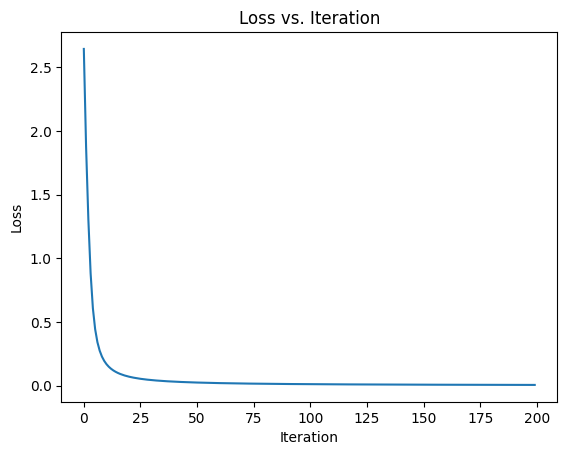

In [210]:
plot_losses(losses)

##### Results at end of iteration

In [211]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [value.data for value in ypred]

print(f'\n- Results at end of iteration -')
print(f'ypred_data: {ypred_data}')
print(f'loss: {loss.data}\n\n')

print(f'Optimized weight and bias matrices')
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)


- Results at end of iteration -
ypred_data: [0.9497440970811232, -0.9489831658287166]
loss: 0.005128373147051807


Optimized weight and bias matrices
--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[-0.17760174  0.77379368]
 [-0.94385685  0.08685296]
 [ 0.90862359  0.31711028]]

input (2, 2):
[[ 2.  3.]
 [ 3. -1.]]

weights_x_inputs (3, 2):
[[ 1.96617758 -1.30659889]
 [-1.62715483 -2.91842351]
 [ 2.76857803  2.4087605 ]]

bias (3, 1):
[[-0.26648551]
 [ 0.07197903]
 [-0.77367136]]

weights_x_inputs_+_bias (3, 2):
[[ 1.69969207 -1.5730844 ]
 [-1.55517579 -2.84644447]
 [ 1.99490667  1.63508914]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.93537057 -0.91751499]
 [-0.91463545 -0.99328295]
 [ 0.96366596  0.92678292]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[ 0.58142089  0.44802563  0.16117358]
 [-0.29012029 -0.73143717 -0.08073523]
 [-1.45436596  0.09454512 -0.71825458

##### Changes in parameters after optimization

In [212]:
# save parameters
param_optmz = [p.data for p in n.parameters()]
param_comp = zip(param_org, param_optmz)

# print(f'i        param_new      param_org      param_dif')
print(f'i   param_optimized      param_org      param_dif')
for i, param_org_new in enumerate(param_comp):
  p_org = param_org_new[0]
  p_new = param_org_new[1]  
  p_dif = p_new - p_org
  print(f'{i:<4} {p_new:>14.10f} {p_org:>14.10f} {p_dif:>14.10f}')  


i   param_optimized      param_org      param_dif
0     -0.1776017352  -0.0173241433  -0.1602775919
1      0.7737936843   0.3754123341   0.3983813502
2     -0.2664855109  -0.2444192365  -0.0220662743
3     -0.9438568501  -0.7889267695  -0.1549300806
4      0.0868529580   0.3390346687  -0.2521817107
5      0.0719790349   0.1512428561  -0.0792638212
6      0.9086235944   0.9558185106  -0.0471949162
7      0.3171102815   0.1431091783   0.1740011032
8     -0.7736713628  -0.7723278572  -0.0013435056
9      0.5814208935   0.9712623563  -0.3898414628
10     0.4480256313   0.5267027655  -0.0786771343
11     0.1611735762   0.1407424670   0.0204311092
12     0.2186360188   0.2017874299   0.0168485889
13    -0.2901202859  -0.1916555892  -0.0984646967
14    -0.7314371715  -0.7304522483  -0.0009849232
15    -0.0807352258  -0.0813683843   0.0006331585
16    -0.6630810200  -0.6660651157   0.0029840957
17    -1.4543659553  -0.4996000628  -0.9547658926
18     0.0945451166   0.2513930174  -0.1568479008


### Build same model with pyTorch 

In [155]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.0121651887893677
Epoch 10 loss: 0.25795215368270874
Epoch 20 loss: 0.012432437390089035
Epoch 30 loss: 0.00031620997469872236

Prediction:
tensor([[ 0.9974],
        [-0.9972]])
Loss: 1.0501457836653572e-05


In [156]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.1927602291107178
Epoch 10 loss: 0.6181687116622925
Epoch 20 loss: 0.13024194538593292
Epoch 30 loss: 0.0101158507168293

Prediction:
tensor([[ 0.9717],
        [-0.9845]])
Loss: 0.0007032828289084136


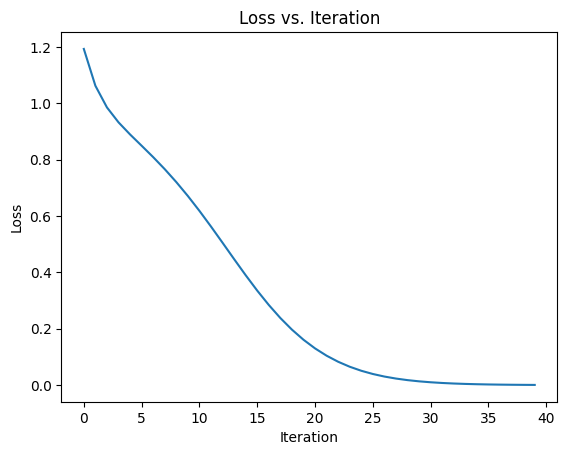

In [157]:
plot_losses(losses)

In [158]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[ 0.2853, -0.5887,  0.3268],
        [-0.3934,  0.3806,  0.1356],
        [-0.4084, -0.5952, -0.4934],
        [-0.1272, -0.0661,  0.5284]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[-1.5223,  1.6080],
        [ 0.2196, -1.4929],
        [-2.1087, -0.8767],
        [-0.9813, -0.0513]])

bT,  torch.Size([4, 1]):
tensor([[ 0.0516],
        [-0.1155],
        [-0.3954],
        [-0.4218]])

w * input + bT,  torch.Size([4, 2]):
tensor([[-1.4707,  1.6595],
        [ 0.1041, -1.6085],
        [-2.5041, -1.2721],
        [-1.4031, -0.4732]])

output,  torch.Size([4, 2]):
tensor([[-0.8997,  0.9302],
        [ 0.1037, -0.9229],
        [-0.9867, -0.8544],
        [-0.8860, -0.4408]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[-0.8351,  0.298

In [159]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [160]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)

# loss = torch.sum(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9717, -0.9845]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(0.0005)

In [161]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9717, -0.9845]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0283,  0.0155]])
squared_difference: tensor([[0.0008, 0.0002]])


tensor(0.0005)

In [162]:
# for item in output.item:
#   print(item)
# type(output)
output.tolist()[0]


[0.971747636795044, -0.9845489859580994]

In [163]:
import numpy as np

def mse_loss(y_true, y_pred):
  """Calculates the mean squared error loss.

  Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.

  Returns:
    The mean squared error loss.
  """

  loss = np.mean((y_true - y_pred)**2)
  return loss

def main():
  """Main function."""

  # y_true = np.array([1, 2, 3, 4, 5])
  y_true = np.array([1.0, -1.0])

  # y_pred = np.array([0, 1, 2, 3, 4])
  # y_pred = np.array([0.9997345209121704, -0.9980572462081909])
  y_pred = np.array(output.tolist()[0])  

  loss = mse_loss(y_true, y_pred)
  print(loss)

if __name__ == "__main__":
  main()

0.0005184649307938827


In [164]:
len(squared_difference)


1

In [165]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(0.0005)

In [166]:
torch.sum((output - torch.tensor(ys))**2)


tensor(0.0010)

##### Check Output and Gradient Calculation with PyTorch

In [167]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <-- result matched micrograd')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <-- result matched micrograd')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <-- result matched micrograd
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <-- result matched micrograd


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [168]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [169]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'parameters in MLP: {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

parameters in MLP: 41

i:  0,   0.4178426610
i:  1,   0.9323534532
i:  2,   0.1075672129
i:  3,   0.2479720467
i:  4,  -0.4704639211
---
i: 36,  -0.8341668642
i: 37,   0.4935390456
i: 38,  -0.6407649650
i: 39,   0.8868283897
i: 40,   0.9100326855


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [170]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 3)
xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [171]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
layer: 0, neuron 0
w0:  0.4178427,   w0.grad:  0.0000000
w1:  0.9323535,   w1.grad:  0.0000000
w2:  0.1075672,   w2.grad:  0.0000000
b:   0.2479720

layer: 0, neuron 1
w0: -0.4704639,   w0.grad:  0.0000000
w1: -0.3469256,   w1.grad:  0.0000000
w2: -0.3809471,   w2.grad:  0.0000000
b:   0.8674992

layer: 0, neuron 2
w0: -0.3819389,   w0.grad:  0.0000000
w1: -0.6682502,   w1.grad:  0.0000000
w2: -0.9504860,   w2.grad:  0.0000000
b:   0.6297142

layer: 0, neuron 3
w0: -0.8625254,   w0.grad:  0.0000000
w1: -0.3832012,   w1.grad:  0.0000000
w2:  0.6022291,   w2.grad:  0.0000000
b:   0.3629252

------
layer: 1, neuron_cnt: 4
----
layer: 1, neuron 0
w0: -0.2085568,   w0.grad:  0.0000000
w1: -0.1133663,   w1.grad:  0.0000000
w2:  0.1205633,   w2.grad:  0.0000000
w3:  0.2774922,   w3.grad:  0.0000000
b:  -0.7073086

layer: 1, neuron 1
w0: -0.2417167,   w0.grad:  0.0000000
w1:  0.6603534,   w1.grad:  0.0000000
w2: -0.2530927,   w2.grad:  0.0000000
w3:  

##### Print Neural Network's Weights and Biases Matrices

In [172]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(4, 3):
[[ 0.41784266  0.93235345  0.10756721]
 [-0.47046392 -0.34692564 -0.38094707]
 [-0.38193892 -0.66825019 -0.95048603]
 [-0.86252545 -0.38320122  0.60222912]]
b_mat(1, 4):
[[0.24797205 0.86749923 0.62971423 0.36292521]]

i: 1
w_mat(4, 4):
[[-0.20855679 -0.11336632  0.12056334  0.27749216]
 [-0.24171667  0.66035336 -0.25309271  0.31565285]
 [-0.57494064  0.34393569  0.00952315  0.17309035]
 [-0.34037658  0.94475761 -0.42913449 -0.7958465 ]]
b_mat(1, 4):
[[-0.70730856  0.75527859  0.34801242  0.63287568]]

i: 2
w_mat(1, 4):
[[-0.83416686  0.49353905 -0.64076496  0.88682839]]
b_mat(1, 1):
[[0.91003269]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [173]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[ 0.41784266  0.93235345  0.10756721]
 [-0.47046392 -0.34692564 -0.38094707]
 [-0.38193892 -0.66825019 -0.95048603]
 [-0.86252545 -0.38320122  0.60222912]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

weights_x_inputs (4, 2):
[[ 3.52517847  0.37495814]
 [-1.6007577  -1.25493966]
 [-1.81814237 -0.95280959]
 [-3.47688367 -1.90326057]]

bias (4, 1):
[[0.24797205]
 [0.86749923]
 [0.62971423]
 [0.36292521]]

weights_x_inputs_plus_bias (4, 2):
[[ 3.77315052  0.62293018]
 [-0.73325847 -0.38744043]
 [-1.18842814 -0.32309535]
 [-3.11395846 -1.54033536]]

output (4, 2):
[[ 0.99894444  0.5531649 ]
 [-0.6250548  -0.36915155]
 [-0.83009074 -0.31230307]
 [-0.99606066 -0.9121767 ]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[-0.20855679 -0.11336632  0.12056334  0.27749216]
 [-0.24171667  0.66035336 -0.25309271  0.31565285]
 [-0.57494064  0.34393569  0.00952315  0.17309035]
 [-0.3

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [174]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.9885013723347925, 0.9858401569531128]
ys:                 [1.0, -1.0]
loss_data:          3.9436933474057465


#### Micrograd backward pass and update parameters

In [175]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0      0.4178426610     0.0369452479           0.05000         0.4159953986
  1      0.9323534532    -0.0123152069           0.05000         0.9329692136
  2      0.1075672129     0.0061575865           0.05000         0.1072593336
  3      0.2479720467     0.0123150713           0.05000         0.2473562931
  4     -0.4704639211     0.1506575623           0.05000        -0.4779967993
  5     -0.3469256443    -0.0509681236           0.05000        -0.3443772381
  6     -0.3809470733     0.0253819342           0.05000        -0.3822161700
  7      0.8674992274     0.0501511023           0.05000         0.8649916723
  8     -0.3819389192    -0.1013979254           0.05000        -0.3768690229
  9     -0.6682501890     0.0340134744           0.05000        -0.6699508627
 10     -0.9504860336    -0.0169775328           0.05000        -0.9496371570
 11      0.6297142321    -0.0337798389

### Improve Prediction with Parameter Iteration 

In [176]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.9878085961543056), Value(data = 0.9845634637585808)]
step: 0, loss: 3.9386407720131853
-------
ypred: [Value(data = 0.9870020962457248), Value(data = 0.9830095986864118)]
step: 1, loss: 3.9324960139844496
-------
ypred: [Value(data = 0.9860480875713005), Value(data = 0.9810774530383225)]
step: 2, loss: 3.9248625307972245
-------
ypred: [Value(data = 0.984897279012874), Value(data = 0.9786113082667756)]
step: 3, loss: 3.915130801382376
-------
ypred: [Value(data = 0.983474653625676), Value(data = 0.9753594877510404)]
step: 4, loss: 3.9023181929208444
-------
ypred: [Value(data = 0.9816599097642618), Value(data = 0.9708902336126707)]
step: 5, loss: 3.884744671859663
-------
ypred: [Value(data = 0.9792468975317283), Value(data = 0.9644049948316895)]
step: 6, loss: 3.8593176749817486
-------
ypred: [Value(data = 0.9758504656254765), Value(data = 0.9542764417609725)]
step: 7, loss: 3.8197796108324336
-------
ypred: [Value(data = 0.9706621335012408), Value(data = 0.936

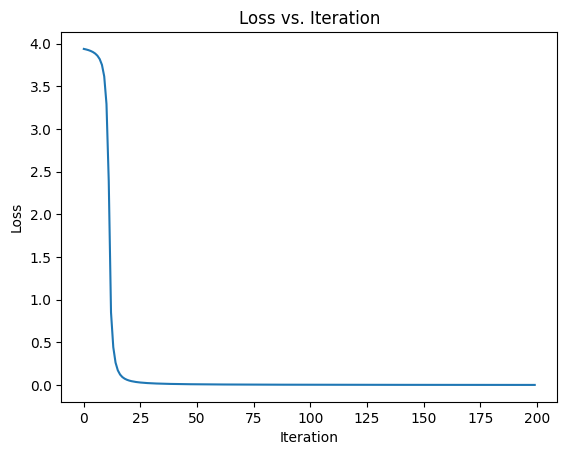

In [177]:
plot_losses(losses)

### Build same model with pyTorch 

In [178]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 0.7745742797851562
Epoch 10 loss: 0.06632467359304428
Epoch 20 loss: 0.0009768520249053836
Epoch 30 loss: 1.0679243132472038e-05

Prediction:
tensor([[ 0.9997],
        [-0.9997]])
Loss: 1.783533747357069e-07


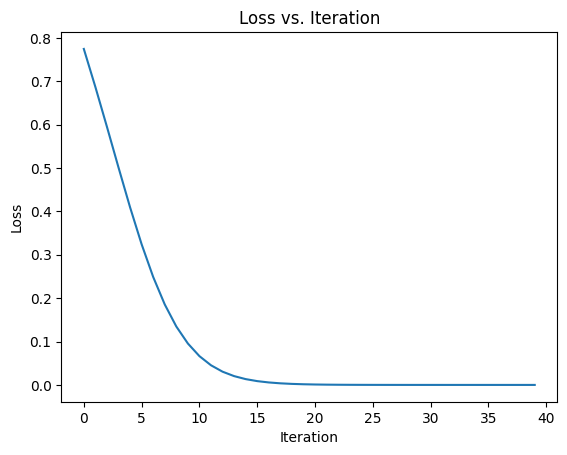

In [179]:
plot_losses(losses)

In [180]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[-0.4973, -0.4777, -0.3312],
        [-0.0657,  0.5880, -0.4572],
        [-0.2146, -0.3407,  0.5330],
        [-0.3432,  0.3731, -0.0889]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[-2.0965, -1.1799],
        [ 2.0898, -1.0136],
        [-1.9842, -0.0366],
        [ 0.5219, -1.4470]])

bT,  torch.Size([4, 1]):
tensor([[0.2278],
        [0.0111],
        [0.0125],
        [0.4860]])

w * input + bT,  torch.Size([4, 2]):
tensor([[-1.8687, -0.9520],
        [ 2.1009, -1.0024],
        [-1.9717, -0.0241],
        [ 1.0079, -0.9610]])

output,  torch.Size([4, 2]):
tensor([[-0.9535, -0.7407],
        [ 0.9705, -0.7626],
        [-0.9620, -0.0241],
        [ 0.7649, -0.7447]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[-0.2947, -0.5318,  

In [181]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [182]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference)
loss

tensor([[ 0.9997, -0.9997]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(2.2632e-07)

In [183]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference) / 2
loss

tensor([[ 0.9997, -0.9997]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0003,  0.0003]])
squared_difference: tensor([[1.0747e-07, 1.1885e-07]])


tensor(1.1316e-07)

In [184]:
difference
len(squared_difference)

1

In [185]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(1.1316e-07)

In [186]:
torch.sum((output - torch.tensor(ys))**2)

tensor(2.2632e-07)